<a href="https://colab.research.google.com/github/Ilagri/Breast-cancer-prediction/blob/main/notebooks/breast_cancer_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Breast Cancer Prediction

## Introduction
Breast cancer is one of the most prevalent cancers among women worldwide, making early and accurate diagnosis crucial for improving patient outcomes. This notebook aims to develop and evaluate machine learning models to predict whether a tumor is benign or malignant based on features extracted from digitized images of a fine needle aspirate (FNA) of a breast mass. The focus will be on leveraging techniques like PCA for dimensionality reduction and models such as SVM for classification.

## Dataset
The analysis utilizes the Breast Cancer Wisconsin (Diagnostic) Dataset, containing 569 observations and 32 features. These features represent various characteristics of cell nuclei present in the FNA, such as radius, texture, perimeter, and area. The target variable, Diagnosis, indicates whether the tumor is benign (B) or malignant (M).


## Purpose
This notebook is structured to:

- **Explore the dataset**: Assess the distribution of features and relationships with the target variable.
- **Preprocess the data**: Encode categorical variables, scale features, and reduce dimensionality using PCA.
- **Build and evaluate models**: Train various classification models and evaluate their performance.
- **Compare model performance**: Assess models using the full feature set and PCA-reduced features.
.
- **Draw conclusions**: Summarize findings and suggest potential improvements.


## Installations

In [ ]:
!pip install ucimlrepo # Install the ucimlrepo package
!pip install shap # Install the shap package

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 9.9 MB/s eta 0:00:00


## Imports

In [ ]:
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc

## Data Loading and Exploration
This section loads the Breast Cancer Wisconsin dataset and conducts an initial exploration. The dataset is clean, with no missing values and features well-suited for classification tasks.


In [ ]:
# Load the data from the UC Irvine Machine Learning Repository
# We use the 'ucimlrepo' package to fetch the dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# Extract the data and convert it into a pandas DataFrame
data = breast_cancer_wisconsin_diagnostic.data.original

# Add an underscore before the numbers in the column names
data.columns = data.columns.str.replace(r'(\d+)', r'_\1', regex=True)

# Preview the first five rows of the dataset
data.head()

,ID,radius_1,texture_1,perimeter_1,area_1,smoothness_1,compactness_1,concavity_1,concave_points_1,symmetry_1,...,texture_3,perimeter_3,area_3,smoothness_3,compactness_3,concavity_3,concave_points_3,symmetry_3,fractal_dimension_3,Diagnosis
0,842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,M
1,842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,M
2,84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,M
3,84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,M
4,84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,M


In [ ]:
# Display basic information about the dataset including data types and missing values
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   569 non-null    int64  
 1   radius_1             569 non-null    float64
 2   texture_1            569 non-null    float64
 3   perimeter_1          569 non-null    float64
 4   area_1               569 non-null    float64
 5   smoothness_1         569 non-null    float64
 6   compactness_1        569 non-null    float64
 7   concavity_1          569 non-null    float64
 8   concave_points_1     569 non-null    float64
 9   symmetry_1           569 non-null    float64
 10  fractal_dimension_1  569 non-null    float64
 11  radius_2             569 non-null    float64
 12  texture_2            569 non-null    float64
 13  perimeter_2          569 non-null    float64
 14  area_2               569 non-null    float64
 15  smoothness_2         569 non-null    flo

In [ ]:
# Provide a summary of the dataset's statistics
# to understand the distribution of numerical features
print(data.describe())

                 ID    radius_1   texture_1  perimeter_1       area_1  \
count  5.690000e+02  569.000000  569.000000   569.000000   569.000000   
mean   3.037183e+07   14.127292   19.289649    91.969033   654.889104   
std    1.250206e+08    3.524049    4.301036    24.298981   351.914129   
min    8.670000e+03    6.981000    9.710000    43.790000   143.500000   
25%    8.692180e+05   11.700000   16.170000    75.170000   420.300000   
50%    9.060240e+05   13.370000   18.840000    86.240000   551.100000   
75%    8.813129e+06   15.780000   21.800000   104.100000   782.700000   
max    9.113205e+08   28.110000   39.280000   188.500000  2501.000000   

       smoothness_1  compactness_1  concavity_1  concave_points_1  symmetry_1  \
count    569.000000     569.000000   569.000000        569.000000  569.000000   
mean       0.096360       0.104341     0.088799          0.048919    0.181162   
std        0.014064       0.052813     0.079720          0.038803    0.027414   
min        0.05263

- **Feature Scale and Range**: The dataset features vary widely in scale, with area-related measurements reaching up to 2500, while smoothness-related values are typically below 0.2. This necessitates feature scaling to ensure balanced model performance.
  
- **Skewed Distributions and Outliers**: Features like `area1`, `perimeter1`, and `radius1` show skewed distributions and potential outliers, which could affect model robustness. Addressing these outliers during preprocessing may improve accuracy.

- **Key Feature Variability**: Compactness and concavity exhibit high variability, indicating their potential importance in distinguishing between benign and malignant tumors. In contrast, symmetry and fractal dimension are more consistent and might require combination with other features for effective classification.

Overall, the dataset is well-structured for predictive modeling tasks focused on classifying benign versus malignant tumors.

## Vizualizing Feature Distributions & Correlations
Visualizing the distribution of features helps identify those that effectively distinguish between benign and malignant tumors.

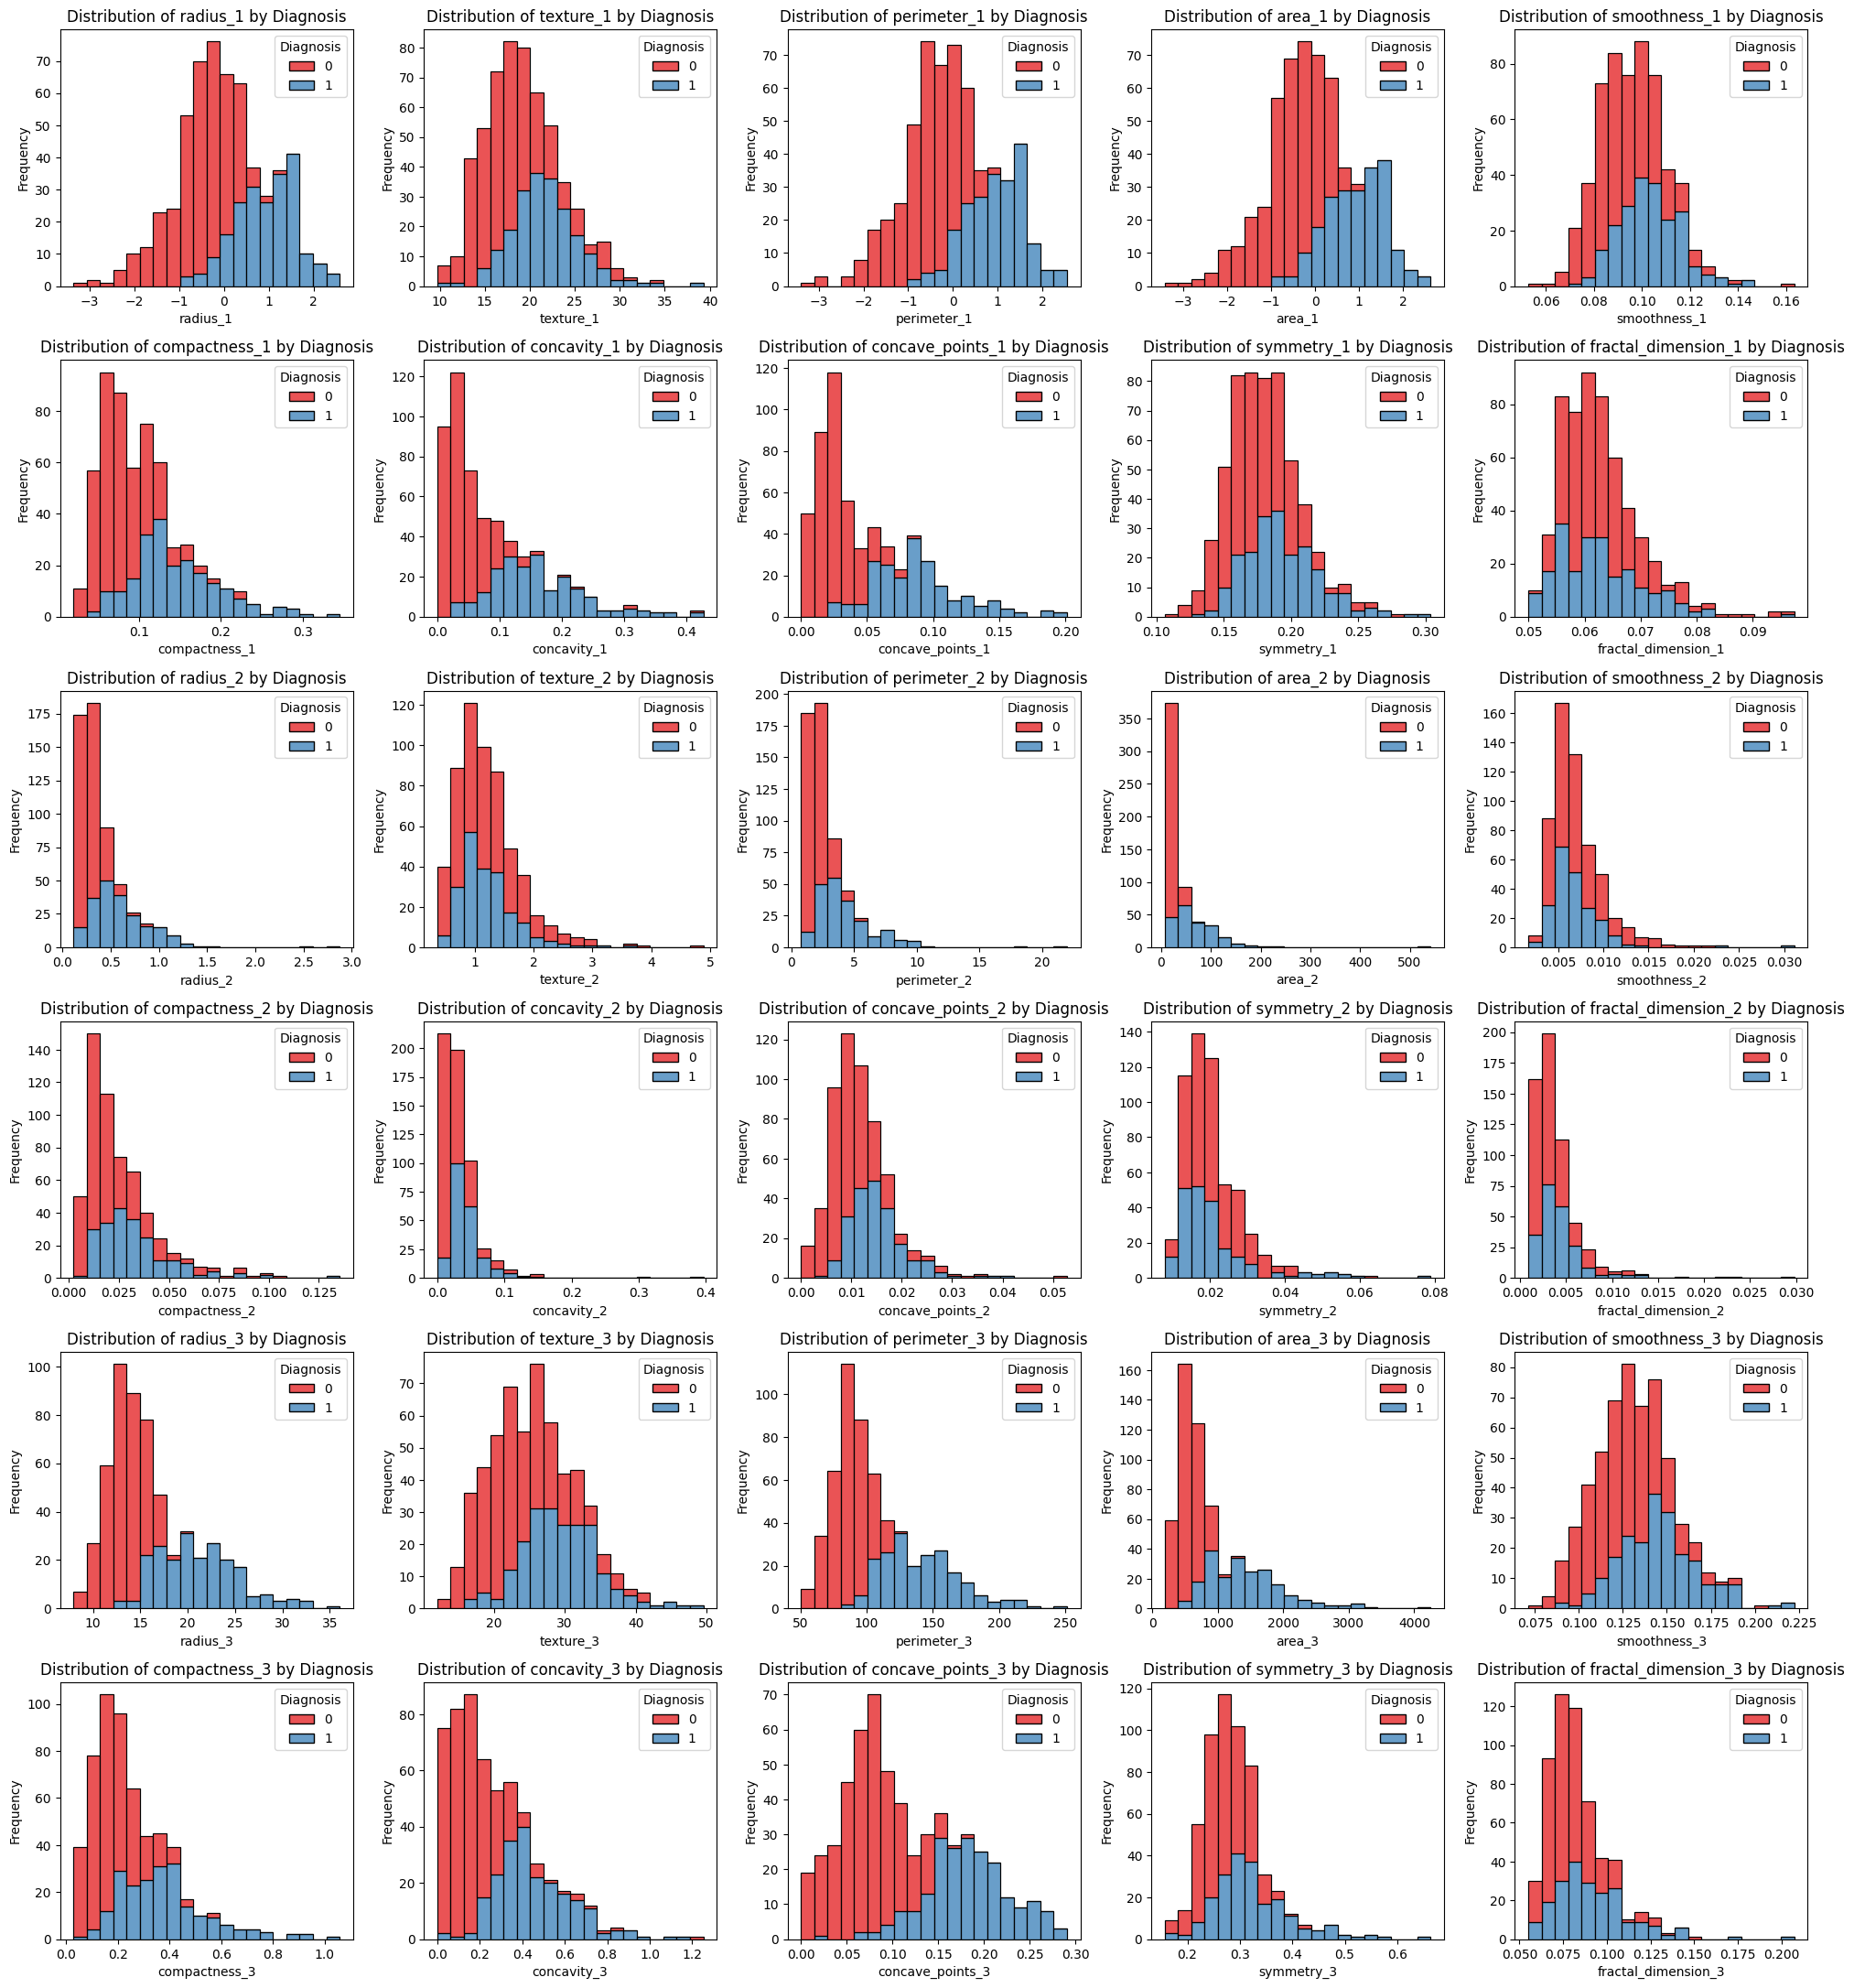

In [ ]:
# Exclude the 'Diagnosis' and 'ID' columns for visualization
features = data.columns.drop(['Diagnosis','ID'])

# Set up the plotting grid
plt.figure(figsize=(20, 25))

# Loop through all features to plot histograms with 'Diagnosis' as hue
for i, feature in enumerate(features):
    plt.subplot(7, 5, i + 1)  # Adjust the grid layout based on the number of features
    sns.histplot(data=data, x=feature, hue='Diagnosis', multiple='stack', bins=20, palette='Set1')
    plt.title(f'Distribution of {feature} by Diagnosis')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

Features such as `radius1`, `perimeter1`, and `area1` display distinct distributions for benign and malignant tumors, suggesting they are strong predictors. However, some skewness indicates a need for careful handling.

Understanding the correlations between features can help identify which features might be redundant (highly correlated) or which are strongly related to the target variable. This can inform feature selection and engineering steps later in the process.

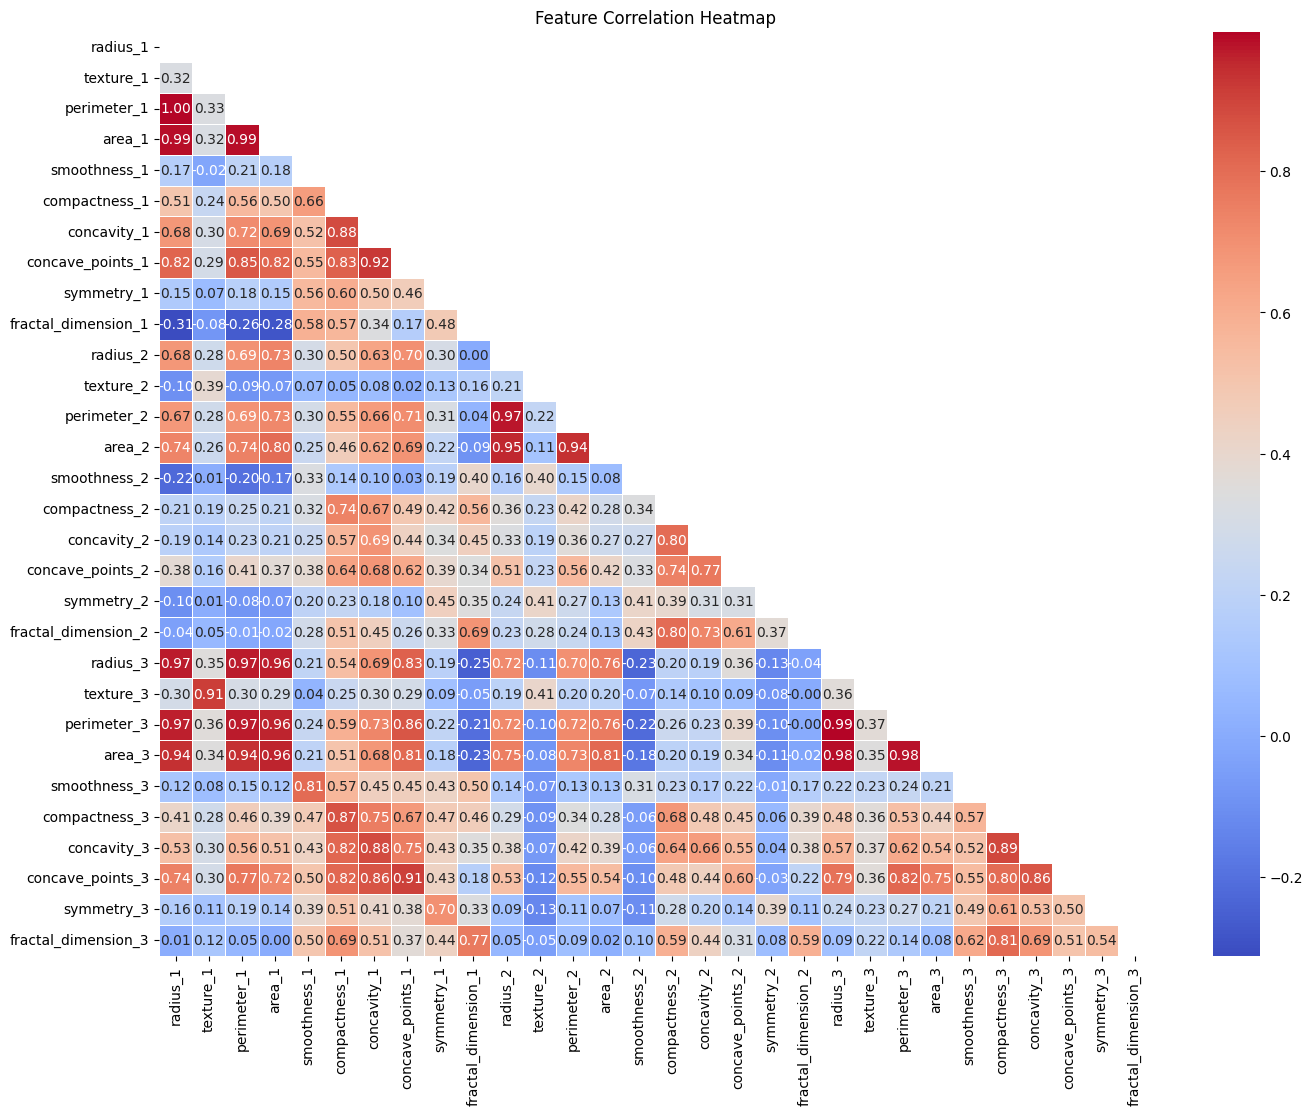

In [ ]:
# Correlation heatmap
relevant_data = data.drop(columns=['Diagnosis','ID'])
plt.figure(figsize=(16, 12))
sns.heatmap(relevant_data.corr(), annot=True, cmap='coolwarm', mask=np.triu(relevant_data.corr()), linewidths=0.5, fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()

Strong correlations among size and shape features (e.g., `radius1`, `perimeter1`, `area1`) suggest potential multicollinearity, which could be mitigated with dimensionality reduction techniques.

## Data Preprocessing
This section prepares the data for modeling by encoding categorical variables, applying feature transformations to stabilize variance, and scaling features. These steps ensure the dataset is in the appropriate format and scale for effective machine learning and dimensionality reduction techniques.

### Encoding the Diagnosis Column
The 'Diagnosis' column contains categorical labels ('B' for benign and 'M' for malignant). Most machine learning algorithms require numerical input, so we convert these labels into numerical values: 0 for benign (B) and 1 for malignant (M). This step is essential for making the Diagnosis column ready for modeling.



In [ ]:
# Convert the 'Diagnosis' column to numeric values: 0 for benign (B), 1 for malignant (M)
data['Diagnosis'] = data['Diagnosis'].map({'B': 0, 'M': 1})

## Splitting the Data
We separate features from the target variable and split the data into training and testing sets to train and evaluate the model.

In [ ]:
# Separate features and target
X = data.drop(columns=['ID', 'Diagnosis'])
y = data['Diagnosis']

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Pipeline Setup
We define a pipeline to ensure consistent preprocessing across cross-validation folds, preventing data leakage and ensuring robust evaluation. This pipeline includes feature transformation, scaling, feature selection, PCA, and the model.

- **Feature Transformation**: To reduce skewness in certain features and make the data more normally distributed without losing information, we apply the Yeo-Johnson power transformation. This step is particularly useful for features with skewed distributions, as it stabilizes variance and improves model performance.

- **Feature Scaling**: After encoding and transforming the features, we scale them to ensure that all features contribute equally to the model. Scaling is crucial when features have different units or scales, standardizing them to a comparable range.

- **Principal Component Analysis (PCA)**: PCA is used to reduce the dimensionality of the dataset while preserving the variance most relevant to classification. However, we also evaluate the model performance with and without PCA to determine whether dimensionality reduction improves results.

In [ ]:
# Define the pipeline steps
pipeline = Pipeline([
    ('transform', PowerTransformer(method='yeo-johnson')),  # Feature transformation
    ('scaler', StandardScaler()),                           # Feature scaling
    ('select', SelectKBest(score_func=f_classif)),           # Feature selection
    ('pca', PCA()),                                          # PCA for dimensionality reduction
    ('model', LogisticRegression(random_state=42))           # Placeholder model
])

## Feature Selection & Grid Search
To optimize the model, we perform grid search with cross-validation, systematically exploring different hyperparameter combinations.

In [ ]:
param_grid = [
    # Logistic Regression with and without PCA
    {
        'select__k': [10, 20, 'all'],                         # Number of top features to select
        'pca': [PCA(n_components=2), PCA(n_components=5), PCA(n_components=10), None],  # Apply PCA or skip it
        'model': [LogisticRegression(random_state=42)],
        'model__C': [0.1, 1, 10]
    },
    # Random Forest with and without PCA
    {
        'select__k': [10, 20, 'all'],
        'pca': [PCA(n_components=2), PCA(n_components=5), PCA(n_components=10), None],
        'model': [RandomForestClassifier(random_state=42)],
        'model__n_estimators': [50, 100]
    },
    # SVM with and without PCA
    {
        'select__k': [10, 20, 'all'],
        'pca': [PCA(n_components=2), PCA(n_components=5), PCA(n_components=10), None],
        'model': [SVC(kernel='linear', probability=True, random_state=42)],
        'model__C': [0.1, 1, 10]
    }
]

In [ ]:
# Initialize the GridSearchCV object with the pipeline and parameter grid
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

Best Parameters: {'model': SVC(kernel='linear', probability=True, random_state=42), 'model__C': 0.1, 'pca': PCA(n_components=10), 'select__k': 'all'}
Best Cross-Validation Accuracy: 0.9758


The grid search results confirm that the best model is an SVM with a linear kernel, regularized with C=0.1, and applied after reducing the dataset to 10 principal components using PCA.

## Model Evaluation


### Accuracy
The model is evaluated on the test set, achieving a high accuracy of 0.9825.

In [ ]:
# Predict on the test set
y_pred = grid_search.predict(X_test)

# Calculate test accuracy
test_accuracy = grid_search.score(X_test, y_test)
print(f"Test Set Accuracy: {test_accuracy:.4f}")

Test Set Accuracy: 0.9825


### Classification Report
The classification report provides detailed metrics on the model's precision, recall, and F1-score for each class, offering insights into how well the model distinguishes between benign and malignant cases.

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99        71
           1       0.98      0.98      0.98        43

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



### Confusion Matrix & ROC Curve
The confusion matrix and ROC curve provide further insights into model performance, showing high precision and recall across classes, with an AUC indicating strong discriminatory power.

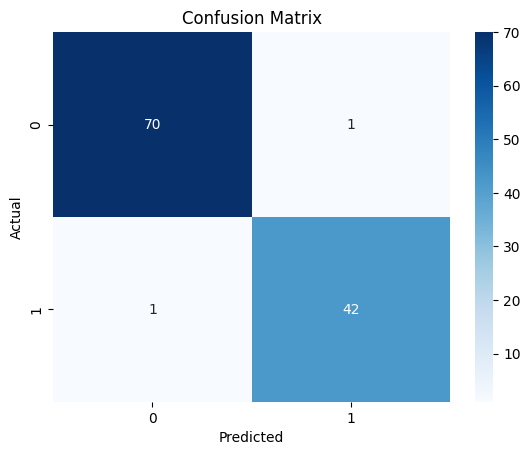

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

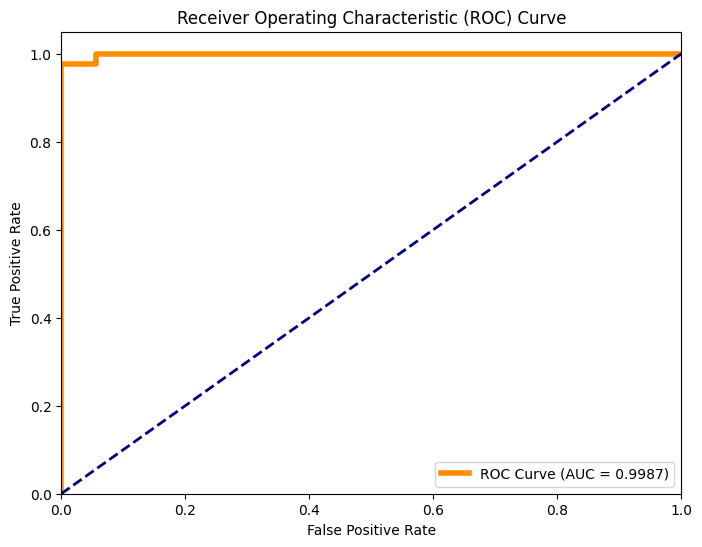

In [ ]:
y_pred_proba = grid_search.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=4, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

The high AUC indicates strong discriminatory power.

# Conclusion
In this project, we successfully built and evaluated several machine learning models for breast cancer prediction. The SVM model, enhanced with PCA and feature selection, achieved the highest cross-validation accuracy. While this model performs well on the test set, further improvements could involve fine-tuning hyperparameters, exploring other algorithms, or using ensemble techniques.